<a href="https://colab.research.google.com/github/rawar/tensorflow-notebooks/blob/master/lstm_text_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Textgenerator based on news

Based on Enriques work of an [Word-level LSTM text generator](https://medium.com/coinmonks/word-level-lstm-text-generator-creating-automatic-song-lyrics-with-neural-networks-b8a1617104fb)

In [1]:
!pip install tf-nightly-gpu

     |████████████████████████████████| 375.4MB 43kB/s 
     |████████████████████████████████| 61kB 26.2MB/s 
     |████████████████████████████████| 491kB 27.3MB/s 
     |████████████████████████████████| 3.1MB 48.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [0]:
url = 'https://gist.githubusercontent.com/rawar/ae4cce269e29c2826163fbca60b544f4/raw/20594a832b44de4b4a5160fb2732399ba09a70e9/reco-content-data.csv'
text_corpus = pd.read_csv(url)

In [4]:
headlines_data_frame = text_corpus['title']
headlines_data_frame = headlines_data_frame.dropna()
headlines_data_frame.head()

0                             Google verkauft Motorola
1    Touchscreen im Winter: Handy-Handschuhe selber...
2    \Bei WhatsApp als Kontakt blockiert: So merkt ...
3    Paper: Facebook stellt neue App im Flipboard-S...
4               WhatsApp: mehr Privatsphäre für Nutzer
Name: title, dtype: object

### lower all words

In [7]:
headlines_data_frame = headlines_data_frame.str.lower()
headlines_data_frame.head(20)

0                              google verkauft motorola
1     touchscreen im winter: handy-handschuhe selber...
2     \bei whatsapp als kontakt blockiert: so merkt ...
3     paper: facebook stellt neue app im flipboard-s...
4                whatsapp: mehr privatsphäre für nutzer
5     tipps: schutz vor gefahren in sozialen netzwerken
6     bluetooth-kopfhörer für sportler: darauf kommt...
7                                     mobistel cynus t5
8                speicherplatz auf ipad & iphone sparen
9     sar-wert beim handy: was sagt er über strahlun...
10    berlin-apps: mit dem smartphone die hauptstadt...
11        beim iphone den sperrcode vergessen: was tun?
12      whatsapp einrichten: einstellungen für anfänger
13       candy crush saga: tipps für die spezialbonbons
14    plants vs. zombies 2: hilfreiche tipps für anf...
15    komfort-handgriffe: praktische shortcuts für a...
16    app-empfehlungen: urlaub buchen mit dem smartp...
17      mit android von smartphones und tablets 

In [8]:
text_in_words = headlines_data_frame.str.split(' ').tolist()
print('Number of sentences:', len(text_in_words))

Number of sentences: 15751


In [9]:
print(text_in_words[15749:15750])

[['fatburner-training:', 'diese', 'übungen', 'sind', 'für', 'männer']]


In [10]:
MAX_WORDS_PER_HEADLINE = 5
for example in text_in_words:
  new_max = len(example)
  if new_max > MAX_WORDS_PER_HEADLINE:
    MAX_WORDS_PER_HEADLINE = new_max
    
print(MAX_WORDS_PER_HEADLINE)

16


### Build a set of (unique) words 

In [0]:
words = set()
for sentence in text_in_words:
  for word in sentence:
    words.add(word)

In [12]:
len(words)

10274

In [0]:
word_indices = dict((c, i) for i, c in enumerate(words))
indices_word = dict((i, c) for i, c in enumerate(words))

In [0]:
SEQUENCE_LEN = 2
MIN_WORD_FREQUENCY = 1
STEP = 1
BATCH_SIZE = 32
EPOCHS = 50

In [0]:
sentences = []
next_words = []
ignored = 0
for sentence in text_in_words:
  for i in range(0, len(sentence) - SEQUENCE_LEN, STEP):
    sentences.append(sentence[i:i + SEQUENCE_LEN])
    next_words.append(sentence[i + SEQUENCE_LEN])

In [0]:
#print(sentences[0])

In [0]:
#print(next_words[0])

In [0]:
#print(sentences[2])

In [0]:
#print(next_words[2])

In [0]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
    # shuffle at unison
    print('Shuffling sentences')

    tmp_sentences = []
    tmp_next_word = []
    for i in np.random.permutation(len(sentences_original)):
        tmp_sentences.append(sentences_original[i])
        tmp_next_word.append(next_original[i])

    cut_index = int(len(sentences_original) * (1.-(percentage_test/100.)))
    x_train, x_test = tmp_sentences[:cut_index], tmp_sentences[cut_index:]
    y_train, y_test = tmp_next_word[:cut_index], tmp_next_word[cut_index:]

    print("Size of training set = %d" % len(x_train))
    print("Size of test set = %d" % len(y_test))
    return (x_train, y_train), (x_test, y_test)

In [22]:
(sentences_train, next_words_train), (sentences_test, next_words_test) = shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences
Size of training set = 98214
Size of test set = 2005


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(words), output_dim=1024),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(words), activation='softmax')
])

In [0]:
def generator(sentence_list, next_word_list, batch_size):
    index = 0
    while True:
        x = np.zeros((batch_size, SEQUENCE_LEN), dtype=np.int32)
        y = np.zeros((batch_size), dtype=np.int32)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index % len(sentence_list)]):
                x[i, t] = word_indices[w]
            y[i] = word_indices[next_word_list[index % len(sentence_list)]]
            index = index + 1
        yield x, y

In [0]:
#optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [0]:
!mkdir checkpoints

In [0]:
file_path = "./checkpoints/lstm-text-gen-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}" % \
                (len(words), SEQUENCE_LEN, MIN_WORD_FREQUENCY)

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

## Keras callback function
Creates a text samples with different diversity values on a random sentence start.

In [0]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(MAX_WORDS_PER_HEADLINE):
            x_pred = np.zeros((1, SEQUENCE_LEN))
            for t, word in enumerate(sentence):
                x_pred[0, t] = word_indices[word]

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word = indices_word[next_index]

            sentence = sentence[1:]
            sentence.append(next_word)

            examples_file.write(" "+next_word)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
    examples_file.flush()


Keras Callback functions to controll the training process

In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)
print_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=20)
callbacks_list = [checkpoint, print_callback, early_stopping]

Sample file to write down the text samples during the training

In [0]:
examples_file = open('examples.txt', "w")

### Model training

In [43]:
history = model.fit_generator(generator(sentences, next_words, BATCH_SIZE),
                    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_data=generator(sentences_test, next_words_test, BATCH_SIZE),
                    validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1)

Epoch 1/50
3132/3132 [==============================] - 50s 16ms/step - loss: 3.3888 - acc: 0.5546 - val_loss: 4.0098 - val_acc: 0.5848
Epoch 2/50
3132/3132 [==============================] - 48s 15ms/step - loss: 2.6136 - acc: 0.6069 - val_loss: 2.4580 - val_acc: 0.6364
Epoch 3/50
3132/3132 [==============================] - 47s 15ms/step - loss: 1.8681 - acc: 0.6755 - val_loss: 1.4827 - val_acc: 0.7292
Epoch 4/50
3132/3132 [==============================] - 48s 15ms/step - loss: 1.2553 - acc: 0.7517 - val_loss: 0.9643 - val_acc: 0.8095
Epoch 5/50
3132/3132 [==============================] - 48s 15ms/step - loss: 0.9116 - acc: 0.8020 - val_loss: 0.7491 - val_acc: 0.8452
Epoch 6/50
3132/3132 [==============================] - 47s 15ms/step - loss: 0.7370 - acc: 0.8284 - val_loss: 0.6321 - val_acc: 0.8552
Epoch 7/50
3132/3132 [==============================] - 48s 15ms/step - loss: 0.6614 - acc: 0.8394 - val_loss: 0.5621 - val_acc: 0.8686
Epoch 8/50
3132/3132 [==========================

### Check accuracy and loss
Be aware of underfitting and overfitting

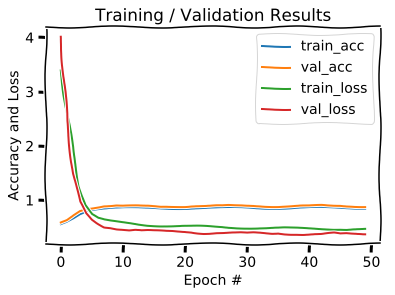

In [44]:
from matplotlib import pyplot

pyplot.xkcd()
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Training / Validation Results')
pyplot.ylabel('Accuracy and Loss')
pyplot.xlabel('Epoch #')
pyplot.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper right')
pyplot.show()


Have a look to our generated examples

In [45]:
!tail -n 25 examples.txt

und filmt droptest aus 30 kilometern höhe im test: fast perfekte sport-kopfhörer unterstützt nun bild-in-bild-anzeige in den vordergrund

----- Generating text after Epoch: 49
----- Diversity:0.3
----- Generating with seed:
"gucci macht"
gucci macht euch zum schlecht gelaunten hund – das endlose das update auf android 6.0 marshmallow erscheint noch
----- Diversity:0.4
----- Generating with seed:
"gucci macht"
gucci macht euch zum schlecht gelaunten hund – das endlose das erste droptest-video ist da – noch mehr
----- Diversity:0.5
----- Generating with seed:
"gucci macht"
gucci macht euch zum schlecht gelaunten hund – das endlose das update auf android 5.1.1 für nexus und
----- Diversity:0.6
----- Generating with seed:
"gucci macht"
gucci macht euch zum schlecht gelaunten hund – aber ohne nintendo switch gerade so erfolgreich wie s5? in
----- Diversity:0.7
----- Generating with seed:
"gucci macht"
gucci macht euch zum schlecht gelaunten hund – das sind die neuen funktionen fürs iphone 6

### Generated model checkpoints

In [0]:
!ls -l checkpoints

total 3302504
-rw-r--r-- 1 root root 177986520 May 14 07:24 lstm-text-gen-epoch001-words10654-sequence2-minfreq1-loss3.4183-acc0.5500-val_loss4.1722-val_acc0.5739
-rw-r--r-- 1 root root 177986520 May 14 07:26 lstm-text-gen-epoch002-words10654-sequence2-minfreq1-loss2.5768-acc0.6009-val_loss2.5593-val_acc0.6146
-rw-r--r-- 1 root root 177986520 May 14 07:27 lstm-text-gen-epoch003-words10654-sequence2-minfreq1-loss1.8062-acc0.6662-val_loss1.5938-val_acc0.7004
-rw-r--r-- 1 root root 177986520 May 14 07:28 lstm-text-gen-epoch004-words10654-sequence2-minfreq1-loss1.1972-acc0.7471-val_loss1.0477-val_acc0.7872
-rw-r--r-- 1 root root 177986520 May 14 07:29 lstm-text-gen-epoch005-words10654-sequence2-minfreq1-loss0.8463-acc0.8021-val_loss0.7990-val_acc0.8289
-rw-r--r-- 1 root root 177986520 May 14 07:31 lstm-text-gen-epoch006-words10654-sequence2-minfreq1-loss0.6675-acc0.8312-val_loss0.6867-val_acc0.8547
-rw-r--r-- 1 root root 177986520 May 14 07:32 lstm-text-gen-epoch007-words10654-sequence2-mi

### Download and store the model and the weights locally

In [0]:
from google.colab import files
model_json = model.to_json()
with open("lstm-text-gen_acc88.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
files.download("lstm-text-gen_acc88.json")

In [0]:
model.save_weights("lstm-text-gen_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
!ls -lh

total 57M
drwxr-xr-x 2 root root 4.0K May 14 08:05 checkpoints
-rw-r--r-- 1 root root  50K May 14 08:26 examples.txt
-rw-r--r-- 1 root root 2.1K May 14 08:28 lstm-text-gen_acc88.json
-rw-r--r-- 1 root root  57M May 14 08:29 lstm-text-gen_model.h5
drwxr-xr-x 1 root root 4.0K May  8 16:22 sample_data


In [0]:
files.download('lstm-text-gen_model.h5')

In [0]:
files.download("examples.txt")

### Helper function to generate a sample text

Used to generate text using a trained model

* model: the trained Keras model (with model.load)
* __indices_word__: a dictionary pointing to the words
* __seed__: a string to be used as seed (already validated and padded)
    :param sequence_length: how many words are given to the model to generate
    :param diversity: is the "temperature" of the sample function (usually between 0.1 and 2)
    :param quantity: quantity of words to generate
    :return: Nothing, for now only writes the text to console
    """

In [0]:
def generate_text(model, indices_word, word_indices, seed,
                  sequence_length, diversity, quantity):
    sentence = seed.split(" ")
    print("----- Generating text")
    print('----- Diversity:' + str(diversity))
    print('----- Generating with seed:"' + seed +'"')

    print(seed)
    for i in range(quantity):
        x_pred = np.zeros((1, sequence_length))
        for t, word in enumerate(sentence):
            x_pred[0, t] = word_indices[word]

        preds = model.predict(x_pred, verbose=0)[0]
   
        next_index = sample(preds, diversity)
        next_word = indices_word[next_index]

        sentence = sentence[1:]
        sentence.append(next_word)

        print(" "+next_word, end="")



In [51]:
generate_text(model, indices_word, word_indices, "neues samsung", 2, 0.5, 10)

----- Generating text
----- Diversity:0.5
----- Generating with seed:"neues samsung"
neues samsung
 galaxy note 9 und bixby 2.0 sollen gleichzeitig erscheinen –

In [52]:
generate_text(model, indices_word, word_indices, "neues ipad", 2, 0.5, 10)

----- Generating text
----- Diversity:0.5
----- Generating with seed:"neues ipad"
neues ipad
 air 2 und charge 2 offiziell vor der masque attack

In [53]:
generate_text(model, indices_word, word_indices, "playstation vr", 2, 0.2, 5)

----- Generating text
----- Diversity:0.2
----- Generating with seed:"playstation vr"
playstation vr
 erscheint am 16. mai ausgeliefert